# Cross-sectional 2D Density Distributions
In this notebook, cross-sectional 2D density distributions are calculated and plotted from all-atom trajectories.

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
import os, sys, json, shutil
from math import asinh, sqrt, pi
import pandas as pd
import glob
import mdtraj as md
from statsmodels.stats.weightstats import DescrStatsW
from mpl_toolkits.axes_grid1 import make_axes_locatable
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
import warnings
warnings.filterwarnings('ignore')
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

/Users/giulio/Repos/SI-peptidebilayer


In [21]:
plt.rcParams.update({'font.size': 12,'xtick.major.pad':3,'ytick.major.pad':3,'figure.dpi':72,
                     'xtick.major.size':6,'ytick.major.size':6,'legend.fontsize':12,
                     'xtick.direction':'out','ytick.direction':'out','axes.labelsize':12,
                     'axes.linewidth':1.2,'xtick.labelsize':12,'ytick.labelsize':12,
                     'xtick.major.width':1.2, 'ytick.major.width':1.2})

In [22]:
def orientation(path,sim,wndw,flip=1):
    wdir = path + '/' + sim 
    if sim[:-1] == 'lys':
        atom = 'NZ'
    elif sim[:-1] == 'his':
        atom = 'ND1'
    else:
        atom = 'NH1'
    #print(atom)
    traj = md.load_xtc(wdir+'/traj'+str(wndw)+'.xtc',top=wdir+'/conf.gro')
    print(traj.n_frames)
    lipids = traj.top.select("resname DOPC")
    tlip = traj.atom_slice(lipids)
    coml = md.compute_center_of_mass(tlip)
    aa = traj.top.select('all and not resname DOPC and not name CL')
    taa = traj.atom_slice(aa)
    coma = md.compute_center_of_mass(taa)
    z_sep = (coml[:,2] - coma[:,2])*flip
    #print(z_ave)
    ca = taa.top.select('name CA')
    nh = taa.top.select('name '+atom)
    #print(len(nh))
    pairs = taa.top.select_pairs(nh,ca)
    canh = md.compute_displacements(taa,pairs)*flip
    z = canh[:,0,2] / np.linalg.norm(canh[:,0,:],axis=1)
    angle = np.arccos(z)/np.pi*180
    edges = np.arange(0,182,2)
    E = edges[:-1]+(edges[1]-edges[0])/2.
    H,e = np.histogram(angle,bins=edges,density=False)
    H = H / np.trapz(H,E)
    H = H / np.sin(E*np.pi/180.)
    #print(a,np.average(E,weights=H))
    weighted_stats = DescrStatsW(E, weights=H, ddof=0)
    plt.plot(E,H)
    np.savetxt(wdir + '/'+sim+'_'+str(wndw)+'.dat',np.c_[E,H])
    print(z_sep.mean(), z_sep.std())
    return z_sep.mean(), z_sep.std(), weighted_stats.mean, weighted_stats.std

def cmSeparation(traj,coma):
    c = traj.top.select('name CG')
    tc = traj.atom_slice(c)
    comc = md.compute_center_of_mass(tc)
    dvec = comc - coma
    x0 = dvec[:,0]; y0 = dvec[:,1]; z0 = dvec[:,2]
    Lx = traj.unitcell_lengths[:,0]; Ly = traj.unitcell_lengths[:,1]; Lz = traj.unitcell_lengths[:,2]
    x0[x0>Lx/2] = x0[x0>Lx/2] - Lx[x0>Lx/2]
    y0[y0>Ly/2] = y0[y0>Ly/2] - Ly[y0>Ly/2]
    z0[z0>Lz/2] = z0[z0>Lz/2] - Lz[z0>Lz/2]
    x0[x0<-Lx/2] = x0[x0<-Lx/2] + Lx[x0<-Lx/2]
    y0[y0<-Ly/2] = y0[y0<-Ly/2] + Ly[y0<-Ly/2]
    z0[z0<-Lz/2] = z0[z0<-Lz/2] + Lz[z0<-Lz/2]
    return x0,y0,z0

# This function calculated density distributions from a CG trajectory
def density(path,sim,wndw,name,flip=1):
    wdir = path + '/' + sim 
    if name[-2:] == 'TL':
        atoms = 'name C35 or name C314 or name C25 or name C214'
    elif name[-2:] == 'HD':
        atoms = 'name P or (name N and resname DOPC)'
    edgesx = np.arange(0,3.75,.15)
    Ex = edgesx[:-1]+(edgesx[1]-edgesx[0])/2.
    traj = md.load_xtc(wdir+'/traj'+str(wndw)+'.xtc',top=wdir+'/conf.gro')
    lipids = traj.top.select("resname DOPC")
    tlip = traj.atom_slice(lipids)
    coml = md.compute_center_of_mass(tlip)
    aa = traj.top.select('all and not resname DOPC and not name CL')
    taa = traj.atom_slice(aa)
    coma = md.compute_center_of_mass(taa)
    z_ave = (coml[:,2] - coma[:,2]).mean()
    print(z_ave)
    edgesy = np.arange(-3.6,3.75,.15) + z_ave*-1 #np.abs(z_ave) # or  
    Ey = edgesy[:-1]+(edgesy[1]-edgesy[0])/2. 
    dx0,dy0,dz0 = cmSeparation(traj,coma)
    pair_c2cat = traj.top.select_pairs('name CG',atoms)
    #print(pair_c2cat.shape,atoms)
    v = md.compute_displacements(traj,pair_c2cat)
    #print(v.shape)
    v[:,:,0] = v[:,:,0] + dx0[:,np.newaxis]
    v[:,:,1] = v[:,:,1] + dy0[:,np.newaxis]
    v[:,:,2] = v[:,:,2] + dz0[:,np.newaxis]
    v = v.reshape((v.shape[0]*v.shape[1],v.shape[2]))
    x0 = v[:,0]; y0 = v[:,1]; z0 = z_ave/np.abs(z_ave) * v[:,2] * flip
    R = np.sqrt(y0*y0+x0*x0)
    h, edges, edges = np.histogram2d(z0,R,bins=[edgesy,edgesx])
    # jacobian correction
    jacobian = pi*.15*np.tile((Ex+.15/2.)[:,np.newaxis]**2-(Ex-.15/2.)[:,np.newaxis]**2,Ey.size)[:,::-1].T
    h = h/jacobian
    Prob = np.append(h[:,::-1],h,axis=1)
    Prob = Prob / traj.n_frames 
    df = pd.DataFrame(data=Prob,index=Ey,columns=np.append(-Ex[::-1],Ex))
    df.to_pickle(wdir + '/'+name+'.p')
    
def plotting(sub,sim,filename,vmin,vmax):
    d = pd.read_pickle(sim+'/'+filename+'TL.p')
    Prob = d.values; Ey = d.index ; Ex = d.columns
    im2 = sub.imshow(Prob/2,extent=[Ex.min(), Ex.max(), Ey.min(), Ey.max()], interpolation='bicubic',
                   cmap=plt.cm.Reds,vmin=vmin,vmax=vmax,origin='lower',alpha=1,aspect='auto')
    d = pd.read_pickle(sim+'/'+filename+'HD.p')
    Prob = d.values; Ey = d.index ; Ex = d.columns
    im1 = sub.imshow(Prob/2,extent=[Ex.min(), Ex.max(), Ey.min(), Ey.max()], interpolation='bicubic',
                   cmap=plt.cm.Greys,vmin=vmin,vmax=vmax,origin='lower',alpha=.7,aspect='auto')
    return im1,im2

def plotOrient(sub,sim,filename):
    E,H = np.loadtxt(sim+'/'+filename+'.dat',unpack=True)
    sub.plot(E,H*100,lw=3,color='k')

### $(Left)$ Cross-sectional 2D Density Distributions of Selected Head and Tail Atoms: Translocation of a Protonated Arginine Monopeptide
### $(Right)$ Angular Orientation of the Arginine Side Chain: Vector Between C$\alpha$ and protonated N w.r.t. the Normal to the Interface

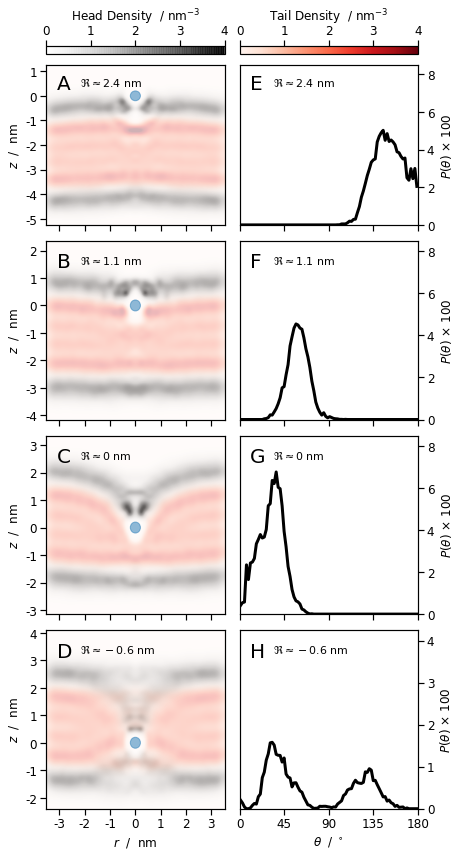

In [23]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': [6.5,12]})
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(nrows=4,ncols=2)
dmax=4
imHD, im2 = plotting(ax1,'allatom/arg1','10',0,dmax)
im1, imTL = plotting(ax1,'allatom/arg1','10',0,dmax)
plotting(ax3,'allatom/arg1','23',0,dmax)
plotting(ax3,'allatom/arg1','23',0,dmax)
plotting(ax5,'allatom/arg1','35',0,dmax)
plotting(ax5,'allatom/arg1','35',0,dmax)
plotting(ax7,'allatom/arg1','40',0,dmax)
plotting(ax7,'allatom/arg1','40',0,dmax)
plotOrient(ax2,'allatom/arg1','arg1_10')
plotOrient(ax4,'allatom/arg1','arg1_23')
plotOrient(ax6,'allatom/arg1','arg1_35')
plotOrient(ax8,'allatom/arg1','arg1_40')
for ax in [ax1,ax3,ax5,ax7]:
    ax.set_xticks(np.arange(-3,3.5,1))
    ax.set_ylabel('$z$  /  nm')
    ax.set_xticklabels(np.tile([''],7))
    #ax.set(adjustable="datalim")
for ax in [ax2,ax4,ax6,ax8]:
    ax.set_ylim(0,8.5); ax.set_xlim(0,180)
    ax.set_xticks(np.arange(0,181,45))
    ax.set_xticklabels(np.tile([''],5))
    ax.set_ylabel(r'$P(\theta)$ $\times$ 100')
    ax.set_yticks(np.arange(0,8.5,2))
    ax.set_yticklabels('{:1g}'.format(i) for i in np.arange(0,8.5,2))
    ax.set(adjustable="box-forced")
    #ax.set_aspect(aspect=180/5.5)
ax8.set_yticklabels('{:1g}'.format(i) for i in np.arange(0,5.5,1))
ax8.set_xticklabels('{:1g}'.format(i) for i in np.arange(0,181,45))
ax7.set_xticklabels('{:1g}'.format(i) for i in np.arange(-3,3.5,1))
ax1.set_ylim(-5.25,1.25); ax3.set_ylim(-4.15,2.35)
ax5.set_ylim(-3.15,3.35); ax7.set_ylim(-2.4,4.1)
ax1.set_yticks(np.arange(-5,1.5,1)); ax3.set_yticks(np.arange(-4,2.5,1))
ax5.set_yticks(np.arange(-3,3.5,1)); ax7.set_yticks(np.arange(-2,4.5,1))
ax1.set_yticklabels('{:1g}'.format(i) for i in np.arange(-5,1.5,1))
ax3.set_yticklabels('{:1g}'.format(i) for i in np.arange(-4,2.5,1))
ax5.set_yticklabels('{:1g}'.format(i) for i in np.arange(-3,3.5,1))
ax7.set_yticklabels('{:1g}'.format(i) for i in np.arange(-2,4.5,1))
ax7.set_xlabel('$r$  /  nm'); ax8.set_xlabel(r'$\theta$  / $^\circ$')
for ax in [ax2,ax4,ax6,ax8]:
    ax.yaxis.set_ticks_position('right'); ax.yaxis.set_label_position('right')
ax1.annotate(r'A',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax3.annotate(r'B',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax5.annotate(r'C',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax7.annotate(r'D',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax2.annotate(r'E',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax4.annotate(r'F',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax6.annotate(r'G',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax8.annotate(r'H',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax1.annotate(r'$\Re \approx 2.4$ nm',xy=(0.19,.87), fontsize=11, xycoords='axes fraction')
ax3.annotate(r'$\Re \approx 1.1$ nm',xy=(0.19,.87), fontsize=11, xycoords='axes fraction')
ax5.annotate(r'$\Re \approx 0$ nm',xy=(0.19,.87), fontsize=11, xycoords='axes fraction')
ax7.annotate(r'$\Re \approx -0.6$ nm',xy=(0.19,.87), fontsize=11, xycoords='axes fraction')
ax2.annotate(r'$\Re \approx 2.4$ nm',xy=(0.19,.87), fontsize=11, xycoords='axes fraction')
ax4.annotate(r'$\Re \approx 1.1$ nm',xy=(0.19,.87), fontsize=11, xycoords='axes fraction')
ax6.annotate(r'$\Re \approx 0$ nm',xy=(0.19,.87), fontsize=11, xycoords='axes fraction')
ax8.annotate(r'$\Re \approx -0.6$ nm',xy=(0.19,.87), fontsize=11, xycoords='axes fraction')

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="5%", pad=.15)
f.add_axes(cax)
cb = f.colorbar(imHD, cax=cax, orientation="horizontal", label=r'Head Density  / nm$^{-3}$', 
                ticks=np.arange(0,dmax+.5,1))
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_ticklabels(['{:1g}'.format(i) for i in np.arange(0,dmax+.5,1)])

divider = make_axes_locatable(ax2)
cax = divider.new_vertical(size="5%", pad=.15)
f.add_axes(cax)
cb = f.colorbar(imTL, cax=cax, orientation="horizontal", label=r'Tail Density  / nm$^{-3}$', 
                ticks=np.arange(0,dmax+.5,1))
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_ticklabels(['{:1g}'.format(i) for i in np.arange(0,dmax+.5,1)])

blue = '#96B7D2'

circle = plt.Circle((0, 0),0.2,color=colors[0],alpha=.5)
ax1.add_artist(circle)
circle = plt.Circle((0, 0),0.2,color=colors[0],alpha=.5)
ax3.add_artist(circle)
circle = plt.Circle((0, 0),0.2,color=colors[0],alpha=.5)
ax5.add_artist(circle)
circle = plt.Circle((0, 0),0.2,color=colors[0],alpha=.5)
ax7.add_artist(circle)

f.tight_layout(w_pad=.3,h_pad=.2)    
f.savefig('figs/densityROrient.pdf')
plt.show()

### Cross-sectional 2D Density Distributions of Selected Head and Tail Atoms: Translocation of a Lysine Monopeptide

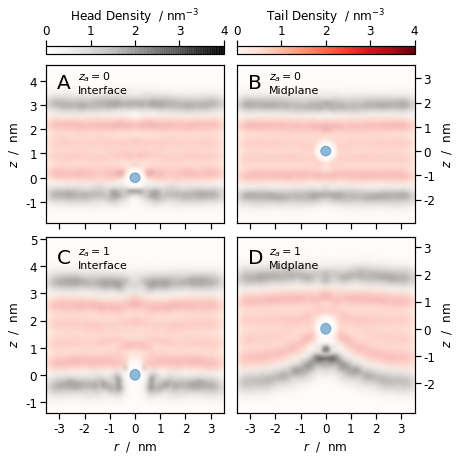

In [24]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': [6.5,6.5]})
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2)
dmax=4
imHD, im2 = plotting(ax1,'allatom/lys0','int',0,dmax)
im1, imTL = plotting(ax2,'allatom/lys0','mid',0,dmax)
plotting(ax3,'allatom/lys1','int',0,dmax)
plotting(ax4,'allatom/lys1','mid',0,dmax)
for ax in f.axes:
    ax.set_xticks(np.arange(-3,3.5,1))
ax1.set_xticklabels(np.tile([''],4))
ax2.set_xticklabels(np.tile([''],4))
ax3.set_xticklabels('{:1g}'.format(i) for i in np.arange(-3,3.5,1))
ax4.set_xticklabels('{:1g}'.format(i) for i in np.arange(-3,3.5,1))
ax1.set_ylim(-1.85,4.65); ax2.set_ylim(-2.95,3.55)
ax3.set_ylim(-1.4,5.1); ax4.set_ylim(-3.1,3.4)
ax1.set_yticks(np.arange(-1,4.5,1)); ax2.set_yticks(np.arange(-2,3.5,1))
ax3.set_yticks(np.arange(-1,5.1,1)); ax4.set_yticks(np.arange(-2,3.5,1))
ax1.set_yticklabels('{:1g}'.format(i) for i in np.arange(-1,4.5,1))
ax2.set_yticklabels('{:1g}'.format(i) for i in np.arange(-2,3.5,1))
ax3.set_yticklabels('{:1g}'.format(i) for i in np.arange(-1,5.1,1))
ax4.set_yticklabels('{:1g}'.format(i) for i in np.arange(-2,3.5,1))
ax3.set_xlabel('$r$  /  nm'); ax4.set_xlabel('$r$  /  nm')
for ax in f.axes:
    ax.set_ylabel('$z$  /  nm')
ax2.yaxis.set_ticks_position('right'); ax4.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right'); ax4.yaxis.set_label_position('right')
ax1.annotate(r'A',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax2.annotate(r'B',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax3.annotate(r'C',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax4.annotate(r'D',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax1.annotate('$z_a=0$\nInterface',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax2.annotate('$z_a=0$\nMidplane',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax3.annotate('$z_a=1$\nInterface',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax4.annotate('$z_a=1$\nMidplane',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="5%", pad=.15)
f.add_axes(cax)
cb = f.colorbar(imHD, cax=cax, orientation="horizontal", label=r'Head Density  / nm$^{-3}$', 
                ticks=np.arange(0,dmax+.5,1))
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_ticklabels(['{:1g}'.format(i) for i in np.arange(0,dmax+.5,1)])

divider = make_axes_locatable(ax2)
cax = divider.new_vertical(size="5%", pad=.15)
f.add_axes(cax)
cb = f.colorbar(imTL, cax=cax, orientation="horizontal", label=r'Tail Density  / nm$^{-3}$', 
                ticks=np.arange(0,dmax+.5,1))
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_ticklabels(['{:1g}'.format(i) for i in np.arange(0,dmax+.5,1)])

blue = '#96B7D2'

circle = plt.Circle((0, 0),0.2,color=colors[0],alpha=.5)
ax1.add_artist(circle)
circle = plt.Circle((0, 0),0.2,color=colors[0],alpha=.5)
ax2.add_artist(circle)
circle = plt.Circle((0, 0),0.2,color=colors[0],alpha=.5)
ax3.add_artist(circle)
circle = plt.Circle((0, 0),0.2,color=colors[0],alpha=.5)
ax4.add_artist(circle)

f.tight_layout(w_pad=.1,h_pad=.2)    
f.savefig('figs/densityK.pdf')
plt.show()

### Cross-sectional 2D Density Distributions of Selected Head and Tail Atoms: Translocation of a Histidine Monopeptide

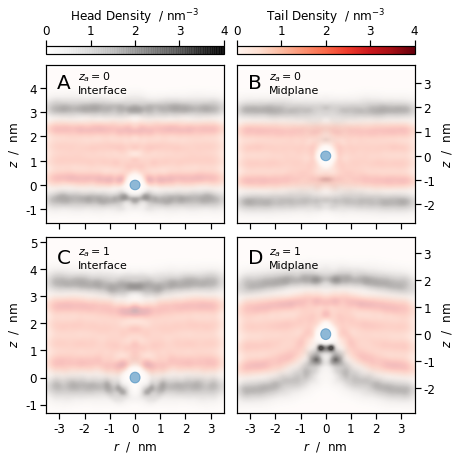

In [25]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': [6.5,6.5]})
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2)
dmax=4
imHD, im2 = plotting(ax1,'allatom/his0','int',0,dmax)
im1, imTL = plotting(ax2,'allatom/his0','mid',0,dmax)
plotting(ax3,'allatom/his1','int',0,dmax)
plotting(ax4,'allatom/his1','mid',0,dmax)
for ax in f.axes:
    ax.set_xticks(np.arange(-3,3.5,1))
ax1.set_xticklabels(np.tile([''],4))
ax2.set_xticklabels(np.tile([''],4))
ax3.set_xticklabels('{:1g}'.format(i) for i in np.arange(-3,3.5,1))
ax4.set_xticklabels('{:1g}'.format(i) for i in np.arange(-3,3.5,1))
ax1.set_ylim(-1.55,4.95); ax2.set_ylim(-2.75,3.75)
ax3.set_ylim(-1.3,5.2); ax4.set_ylim(-2.9,3.6)
ax1.set_yticks(np.arange(-1,4.5,1)); ax2.set_yticks(np.arange(-2,3.5,1))
ax3.set_yticks(np.arange(-1,5.1,1)); ax4.set_yticks(np.arange(-2,3.5,1))
ax1.set_yticklabels('{:1g}'.format(i) for i in np.arange(-1,4.5,1))
ax2.set_yticklabels('{:1g}'.format(i) for i in np.arange(-2,3.5,1))
ax3.set_yticklabels('{:1g}'.format(i) for i in np.arange(-1,5.1,1))
ax4.set_yticklabels('{:1g}'.format(i) for i in np.arange(-2,3.5,1))
ax3.set_xlabel('$r$  /  nm'); ax4.set_xlabel('$r$  /  nm')
for ax in f.axes:
    ax.set_ylabel('$z$  /  nm')
ax2.yaxis.set_ticks_position('right'); ax4.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right'); ax4.yaxis.set_label_position('right')
ax1.annotate(r'A',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax2.annotate(r'B',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax3.annotate(r'C',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax4.annotate(r'D',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax1.annotate('$z_a=0$\nInterface',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax2.annotate('$z_a=0$\nMidplane',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax3.annotate('$z_a=1$\nInterface',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax4.annotate('$z_a=1$\nMidplane',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="5%", pad=.15)
f.add_axes(cax)
cb = f.colorbar(imHD, cax=cax, orientation="horizontal", label=r'Head Density  / nm$^{-3}$', 
                ticks=np.arange(0,dmax+.5,1))
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_ticklabels(['{:1g}'.format(i) for i in np.arange(0,dmax+.5,1)])

divider = make_axes_locatable(ax2)
cax = divider.new_vertical(size="5%", pad=.15)
f.add_axes(cax)
cb = f.colorbar(imTL, cax=cax, orientation="horizontal", label=r'Tail Density  / nm$^{-3}$', 
                ticks=np.arange(0,dmax+.5,1))
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_ticklabels(['{:1g}'.format(i) for i in np.arange(0,dmax+.5,1)])

blue = '#96B7D2'

circle = plt.Circle((0, 0),0.2,color=colors[0],alpha=.5)
ax1.add_artist(circle)
circle = plt.Circle((0, 0),0.2,color=colors[0],alpha=.5)
ax2.add_artist(circle)
circle = plt.Circle((0, 0),0.2,color=colors[0],alpha=.5)
ax3.add_artist(circle)
circle = plt.Circle((0, 0),0.2,color=colors[0],alpha=.5)
ax4.add_artist(circle)

f.tight_layout(w_pad=.1,h_pad=.2)    
f.savefig('figs/densityH.pdf')
plt.show()

### Umbrella Sampling Histograms and Potential of Mean Force of Membrane Translocation for a Neutral Histidine Monopeptide

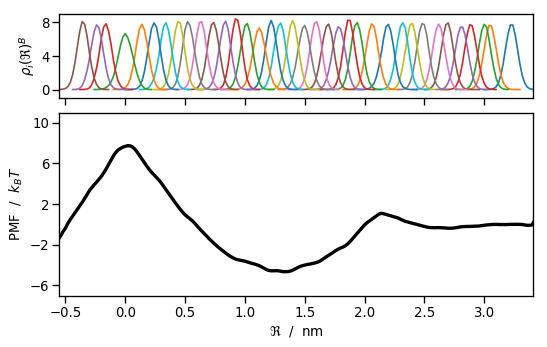

In [26]:
plt.rcParams.update({'font.size': 12,'xtick.major.pad':3,'ytick.major.pad':3,'figure.dpi':80,
                     'xtick.major.size':6,'ytick.major.size':6,'legend.fontsize':12,
                     'xtick.direction':'out','ytick.direction':'out','axes.labelsize':12,
                     'axes.linewidth':1.2,'xtick.labelsize':12,'ytick.labelsize':12,
                     'xtick.major.width':1.2, 'ytick.major.width':1.2})
plt.rcParams.update({'figure.figsize': [7, 4.5]})

path = 'allatom/his0/pullx/'

RT = 8.3145*0.310 # thermal energy, (kJ/mol)
K = 1000. # harmonic force constant, (kJ/mol/nm^2)
Nw = 36 # number of simulations

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan=2, colspan=1)

for i in range(Nw): 
    rc,rhoB = np.loadtxt(path+'hist'+str(i+1)+'.dat',unpack=True)
    norm = np.trapz(rhoB,rc)
    ax1.plot(rc[rhoB!=0],rhoB[rhoB!=0]/norm)
    
ax1.set_ylabel(r'$\rho_i(\Re)^B$')

rc,PMF = np.loadtxt(path+'PMF4000.dat',unpack=True)
ax2.plot(rc,PMF,lw=3,color='k',label='4000')
ax2.set_ylabel(r'PMF  /  $k_BT$')
ax2.set_xlabel(r'$\Re$  /  nm')

ax2.set_ylim(-7,11)
ax2.set_yticks(np.arange(-6,12,4))

ax1.set_ylim(-1,9)
ax1.set_yticks(np.arange(0,9,4))

for ax in [ax1,ax2]:
    ax.set_xticks(np.arange(-.5,3.6,.5))
    ax.set_xlim(-.55,3.41)
ax1.set_xticklabels(np.tile([''],9))

plt.tight_layout(h_pad=.2)    
plt.savefig('figs/wham.pdf')
plt.show()